Expectation maximization demo
===========

This is an implementation of EM clustering on synthetic data.

In [1]:
import numpy as np
from scipy.misc import logsumexp
import matplotlib.pyplot as plt
%pylab inline

Populating the interactive namespace from numpy and matplotlib


Generate true data

In [2]:
V = 100
K = 3
N = 1000
M = 50 #expected number of words per document; generate from a poisson distribution

In [3]:
# generate the word distribution P(w | k)
true_theta = np.zeros((K,V))
for k in range(K):
    true_theta[k,] = np.random.dirichlet(0.1*np.ones(V))
# generate the prior over classes
true_pi = np.random.dirichlet(np.ones(K))

In [4]:
# generate the observations
true_k = np.random.multinomial(1,true_pi,N)
w = np.zeros((N,V))
for i in range(N):
    N_i = np.random.poisson(M)
    w[i,] = np.random.multinomial(N_i,true_k[i,].dot(true_theta))

In [5]:
params = {'text.latex.preamble' : [r'\usepackage{siunitx}', r'\usepackage{amsmath}']}
plt.rcParams.update(params)
matplotlib.rc('text', usetex = True)
matplotlib.rc('font', **{'family' : "sans-serif"})
plt.rcParams.update({'figure.autolayout': True})

(-3.4599180434485888,
 72.459918043448596,
 -3.2658688695177402,
 68.265868869517732)

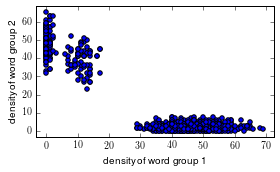

In [10]:
fig = plt.figure(figsize=(4,2.5));
ax = fig.add_subplot(1,1,1);

theta_comparison_0 = (true_theta[0,] / true_theta[1,] > 2.5)*1.0;
theta_comparison_1 = (true_theta[1,] / true_theta[0,] > 2.5)*1.0;

ax.scatter(np.dot(w,theta_comparison_0),
           np.dot(w,theta_comparison_1));
ax.set_xlabel('density of word group 1');
ax.set_ylabel('density of word group 2');
ax.axis('tight');
#fig.savefig('wsi-synth-scatter.pdf')

Now do EM

In [11]:
def initialize(K,V):
    theta = np.random.dirichlet(np.ones(V),K)
    pi = np.ones(K) / K
    return theta, pi

In [12]:
def eStep(w,theta,pi):
    # first term: log P(w | z=k)
    # second term: log P(z=k)
    q = w.dot(np.log(theta.T)) + np.log(pi)
    #q = q - q.max(axis=1).reshape(q.shape[0],-1)
    # log-normalize
    output = np.exp(q.T - logsumexp(q,axis=1)).T
    return output

In [13]:
def mStep(w,q,alpha=.0001):
    # unnormalized theta
    theta = q.T.dot(w) + alpha
    theta = (theta.T / theta.sum(axis=1)).T
    pi = q.sum(axis=0).T
    pi/=sum(pi)
    return theta,pi

In [14]:
def score(w,q,theta,pi):
    return (q * (w.dot(np.log(theta.T)) + np.log(pi).T - np.log(q+.00000000001))).sum()

In [15]:
def scoreSimple(w,q,theta,pi):
    eq_log_p_w = (q * w.dot(np.log(theta.T))).sum(axis=1)
    eq_log_p_z = (q * np.log(pi).T).sum(axis=1)
    eq_log_q_z = (q * np.log(q)).sum(axis=1)
    return (eq_log_p_w + eq_log_p_z - eq_log_q_z).sum()

In [16]:
theta,pi = initialize(K,V)
q = eStep(w,theta,pi)
print score(w,q,theta,pi), scoreSimple(w,q,theta,pi)

-242017.066781 -242017.066781


In [17]:
def em(w,K,num_its=100,verbose=True,alpha=0.0001):
    N,V = w.shape
    theta,pi = initialize(K,V)
    scores = []
    for it in range(num_its):
        q = eStep(w,theta,pi)
        if any(np.isnan(q)):
            raise ValueError('why now?')
        if verbose: print it, score(w,q,theta,pi),
        theta,pi = mStep(w,q,alpha)
        scores.append(score(w,q,theta,pi))
        if verbose: print scores[-1]
    return scores,theta,pi

In [18]:
em(w,5,num_its=10);

0 -232171.835312 -143644.609126
1 -139143.810096 -137876.259714
2 -137869.368754 -137862.528964
3 -137862.516564 -137862.515553
4 -137862.515553 -137862.515553
5 -137862.515553 -137862.515553
6 -137862.515553 -137862.515553
7 -137862.515553 -137862.515553
8 -137862.515553 -137862.515553
9 -137862.515553 -137862.515553


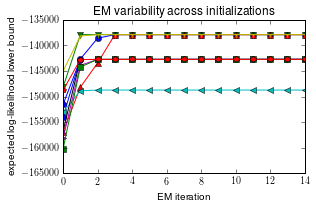

In [26]:
fig = plt.figure(figsize=(4.5,3))
ax = fig.add_subplot(1,1,1)

syms = ['o','v','^','<','>','1','3','8','s','p']
for sym in syms:
    ax.plot(em(w,3,num_its=15,verbose=False)[0],sym+'-')
    
ax.set_xlabel('EM iteration')
ax.set_ylabel('expected log-likelihood lower bound')
ax.set_title('EM variability across initializations')
#fig.savefig('em-sensitivity.pdf')

# Word Sense Induction #

In [27]:
datadir = 'books'

In [28]:
from glob import glob
import os
from collections import Counter, defaultdict

In [29]:
from nltk.tokenize import sent_tokenize, word_tokenize
from nltk.corpus import stopwords

In [30]:
def getAllInstances(datadir,instance_getter):
    instances = [] #list of Counters
    for filename in glob(os.path.join(datadir,'*.txt')):
        with open(filename) as fin:
            instances.extend(instance_getter(fin))
    return instances

In [31]:
def getWordNeighbors(fin,word,window_size=2):
    outputs = []
    def getNeighborsAux(wordlist):
        if word in wordlist:
            idx = wordlist.index(word)
            neighborhood = [wordlist[i] for i in 
                            range(max(0,idx-window_size),idx) 
                            + range(idx+1,min(idx+window_size+1,len(wordlist)))]
            return [neighborhood] + getNeighborsAux(wordlist[idx+1:])
        return []
    
    for line in fin:
        for sent in sent_tokenize(line.decode('ascii','ignore')):
            words = [word_item.lower() for word_item in word_tokenize(sent) if word_item.isalpha()]
            outputs.extend(getNeighborsAux(words))
    return outputs

In [32]:
def getWholeDoc(fin,word):
    output = []
    whole_doc = []
    for line in fin:
        for sent in sent_tokenize(line.decode('ascii','ignore')):
            whole_doc.extend([word_item.lower() for word_item in word_tokenize(sent) if word_item.isalpha()])
    if word in whole_doc:
        return [whole_doc]
    return []

In [34]:
with open('books/1632.txt') as fin:
    for line in fin:
        for sent in sent_tokenize(line):
            print sent
with open('books/1632.txt') as fin:
    print getWordNeighbors(fin,'town',2)

 The fictional town of Grantville, West Virginia (modeled on the real West Virginia town of Mannington) and its power plant are displaced in space-time, through a side effect of a mysterious alien civilization.
A hemispherical section of land about three miles in radius measured from the town center is transported back in time and space from April 2000 to May 1631, from North America to central Germany.
The town is thrust into the middle of the Thirty Years' War, in the German province of Thuringia in the Thuringer Wald, near the fictional German free city of Badenburg.
This Assiti Shards effect occurs during a wedding reception, accounting for the presence of several people not native to the town, including a doctor and his daughter, a paramedic.
Real Thuringian municipalities located close to Grantville are posited as Weimar, Jena, Saalfeld and the more remote Erfurt, Arnstadt, and Eisenach well to the south of Halle and Leipzig.
Grantville, led by Mike Stearns, president of the loca

In [47]:
window_size = 5
word = 'plant'

In [48]:
instances = getAllInstances(datadir,lambda fin : getWordNeighbors(fin,word,window_size))

In [494]:
instances = getAllInstances(datadir,lambda fin : getWholeDoc(fin,word))

In [37]:
def getDataFromInstances(instances,min_count=1):
    stoplist = stopwords.words('english')
    counts = sum([Counter(set(inst)) for inst in instances])
    vocab = [word for word,count in counts.iteritems() if count > min_count and word not in stoplist]
    V = len(vocab)
    x = np.zeros((len(instances),V))
    for i,inst in enumerate(instances):
        for word in inst:
            if word in vocab:
                x[i,vocab.index(word)] += 1
    print x.shape
    return x,vocab

In [49]:
x,vocab=getDataFromInstances(instances,min_count=1)

(54, 18)


In [53]:
print len(instances), x.shape

54 (54, 18)


In [54]:
best_score = -sys.float_info.max
best_theta = None
best_pi = None
for _ in range(30):
    scores,theta,pi = em(x,2,alpha=1.,verbose=False)
    if scores[-1] > best_score:
        best_score = scores[-1]
        best_theta = theta
        best_pi = pi
print best_score
base_rate = x.sum(axis=0)
final_q = eStep(x,best_theta,best_pi)
for k,cluster in enumerate(best_theta):
    print 'CLUSTER',k,best_pi[k],'--------------------'
    print [str(vocab[i]) for i in (-np.log(cluster) + np.log(base_rate)).argsort()[:10]]
    for i in (-final_q[:,k]).argsort()[:5]:
        if len(instances[i]) == window_size * 2:
            print ' '.join(instances[i][:window_size]+[word]+instances[i][window_size:])
    print ''

-136.358310911
CLUSTER 0 0.312398884841 --------------------
['nuclear', 'new', 'power', 'assembly', 'xymos', 'house', 'idea', 'network', 'tells', 'job']
and the soviet union and plant nuclear weapons and new terrorist
build a small house and plant a garden if he cleared
of mannington and its power plant are displaced in through a

CLUSTER 1 0.687601115159 --------------------
['suitable', 'feeds', 'species', 'around', 'network', 'job', 'tells', 'idea', 'life', 'house']
this the rain feeds the plant the plant feeds the animal
the greater availability of suitable plant and animal species for domestication
area provided it with more plant and animal species suitable for



In [589]:
thresh = 1.5
base_theta = x.sum(axis=0)/x.sum()
th_0 = (best_theta[0,:] / base_theta > thresh)*1.
th_1 = (best_theta[1,:] / base_theta > thresh)*1.
th_2 = (best_theta[2,:] / base_theta > thresh)*1.

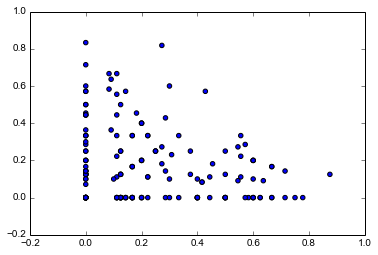

In [593]:
scatter(np.dot(x,th_1)/x.sum(axis=1),
        np.dot(x,th_2)/x.sum(axis=1))

In [467]:
x.shape

(172, 58)

In [468]:
best_theta.shape

(4, 58)

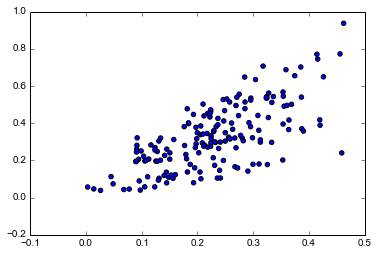

In [514]:
scatter(np.dot(x,best_theta[0,:].T),
        np.dot(x,best_theta[1,:].T))

In [ ]:
scatter(best_theta[:,3])

# Lesk Algorithm #

In [57]:
from nltk.corpus import wordnet as wn

In [80]:
stoplist = stopwords.words('english')

In [81]:
def0 = set([word for word in wn.synsets('plant')[0].definition().split() if word not in stoplist])

In [82]:
def1 = set([word for word in wn.synsets('plant')[1].definition().split() if word not in stoplist])

In [83]:
lesk_counts = [[len(set(instance).intersection(defset)) for instance in instances] for defset in [def0,def1]]

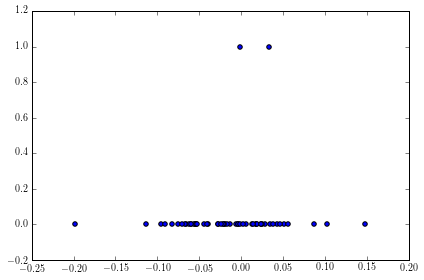

In [85]:
scatter(np.array(lesk_counts[0])+0.05*np.random.randn(len(instances)),
        np.array(lesk_counts[1])+0.0*np.random.randn(len(instances)))